In [118]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Classifier(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))

In [6]:
def count_word_address(data):
    data['address'] = data.address.apply(lambda x: str(x).replace(',,', ''))
    data['word_count_address'] = data.address.apply(lambda x: len([st for st in str(x).split(' ') if len(st) > 0]))
    return data


def remove_email(data):
    data.email = data.email.apply(lambda x: str(x).lower())
    email_group = data.groupby('email')['contact_id'].count().reset_index(name='amount').sort_values('amount',
                                                                                                     ascending=False)
    email_l8 = data.groupby('email')['l8'].mean().reset_index(name='percentage_l8')
    email_l8.percentage_l8 = email_l8.percentage_l8.apply(lambda x: x / data.shape[0])
    email_statistic = pd.merge(email_group, email_l8, on='email', how='left')
    email_removing = email_statistic.email.values[0:5]
    data = data[~data.email.isin(email_removing)]
    return data

In [145]:
data = pd.read_csv('data/data_combined_changed.csv')
data = data[data.price != 2019]
data = data.sort_values('created_at', ascending=True)

data = remove_email(data)
data = count_word_address(data)

df_l8 = data[data.l8 == 1]
df_not_l8 = data[data.l8 < 1].iloc[0:df_l8.shape[0] + 1, :]
data = pd.concat([df_l8, df_not_l8], axis=0)
training = data.loc[:, ['created_at', 'sa', 'price', 'l8_c3_course_2w', 'tutin_l8_c3_course_2w',
                        'c3_course_buyed_1w', 'gdp_province', 'l8_c3_marketer_ratio',
                        'l8_c3_marketer_course', 'tutin_l8_c3_marketer',
                        'tutin_l8_c3_marketer_course', 'contact_id', 'l8', 'word_count_address']]
training['price_gdp'] = np.tanh(0.2 * (training.gdp_province / training.price))
training.loc[:, ['created_at', 'sa', 'l8_c3_course_2w', 'tutin_l8_c3_course_2w',
                 'l8_c3_marketer_ratio', 'price_gdp',
                 'l8_c3_marketer_course', 'tutin_l8_c3_marketer',
                 'tutin_l8_c3_marketer_course', 'contact_id', 'l8', 'word_count_address']].to_csv('data_changed.csv')

all_cols = ['sa','l8_c3_course_2w', 'tutin_l8_c3_course_2w','price_gdp', 'l8_c3_marketer_ratio', 
            'l8_c3_marketer_course','tutin_l8_c3_marketer', 'tutin_l8_c3_marketer_course', 'word_count_address']

for col in all_cols:
    scaler = StandardScaler()
    training[col] = scaler.fit_transform(training[col].values.reshape(-1, 1))

    

# X, y = training.loc[:,['sa','l8_c3_course_2w', 'tutin_l8_c3_course_2w','price_gdp',
#                        'l8_c3_marketer_ratio', 'l8_c3_marketer_course','tutin_l8_c3_marketer',
#                        'tutin_l8_c3_marketer_course', 'word_count_address']], to_categorical(training.l8, num_classes=2)

X, y = training.loc[:, all_cols], training.l8

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

In [21]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import itertools

In [13]:
svc = Classifier(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [14]:
svc.grid_fit(X=X_train, Y=y_train)

In [15]:
svc.grid_predict(X_test, y_test)

Precision: 65.85 %


In [16]:
# code from -> SKLEARN Documentation.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[16989  7557]
 [ 9141 15213]]


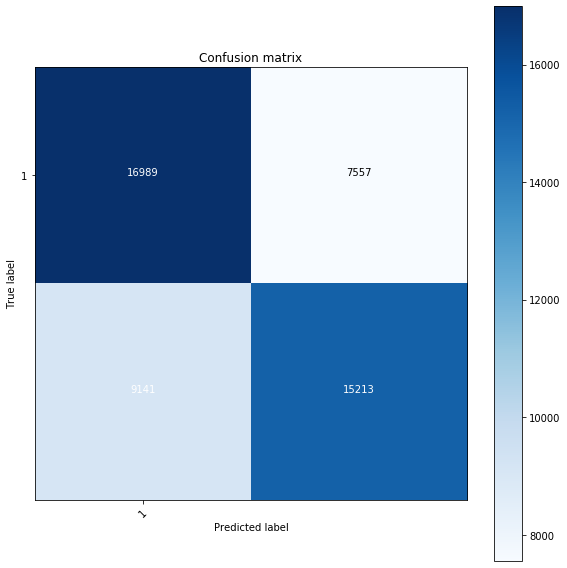

In [23]:
class_names = [i for i in range(1,2)]
cnf = confusion_matrix(y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [24]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

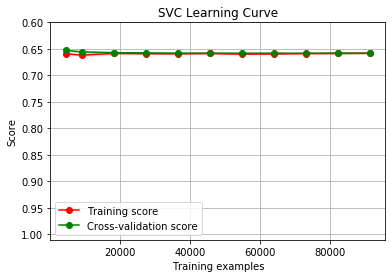

In [25]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC Learning Curve", X_train, y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [28]:
lr = Classifier(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)
lr.grid_fit(X_train, y_train)
lr.grid_predict(X_test, y_test)

Precision: 65.83 %


Confusion matrix, without normalization
[[16891  7655]
 [ 9053 15301]]


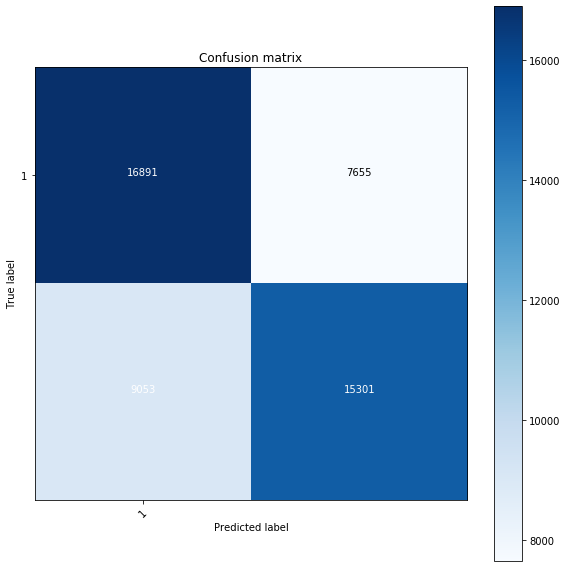

In [30]:
cnf = confusion_matrix(y_test, lr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

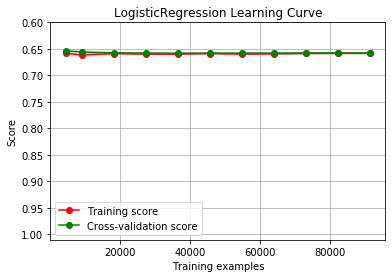

In [31]:
g = plot_learning_curve(lr.grid.best_estimator_, "LogisticRegression Learning Curve", X_train, y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [32]:
knn = Classifier(clf = KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X_train, y_train)
knn.grid_predict(X_test, y_test)

Precision: 67.77 %


Confusion matrix, without normalization
[[16751  7795]
 [ 7966 16388]]


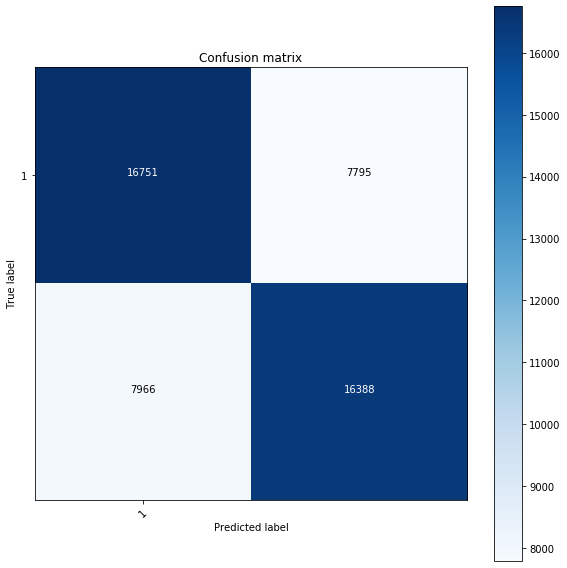

In [33]:
cnf = confusion_matrix(y_test, knn.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

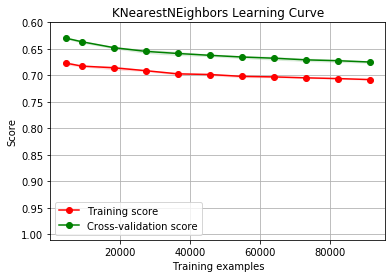

In [34]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNearestNEighbors Learning Curve", X_train, y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 67.81 %
Confusion matrix, without normalization
[[17530  7016]
 [ 8724 15630]]


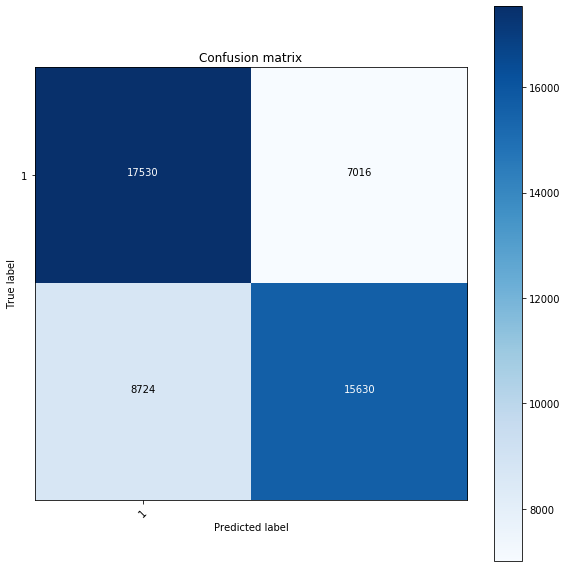

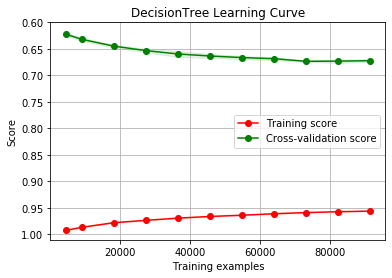

In [35]:
tr = Classifiersifier(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X_train, y_train)
tr.grid_predict(X_test, y_test)
cnf = confusion_matrix(y_test, tr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

g = plot_learning_curve(tr.grid.best_estimator_, "DecisionTree Learning Curve", X_train, y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [48]:
from sklearn.metrics import precision_recall_fscore_support

In [36]:
rf = Classifier(clf = RandomForestClassifier)
rf.grid_search(parameters = [{'criterion':['entropy', 'gini'], 
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf.grid_fit(X_train, y_train)
rf.grid_predict(X_test, y_test)

Precision: 71.28 %


In [50]:
precision_recall_fscore_support(rf.predictions, y_test)

(array([0.74, 0.69]),
 array([0.7 , 0.72]),
 array([0.72, 0.7 ]),
 array([25680, 23220], dtype=int64))

Confusion matrix, without normalization
[[18092  6454]
 [ 7588 16766]]


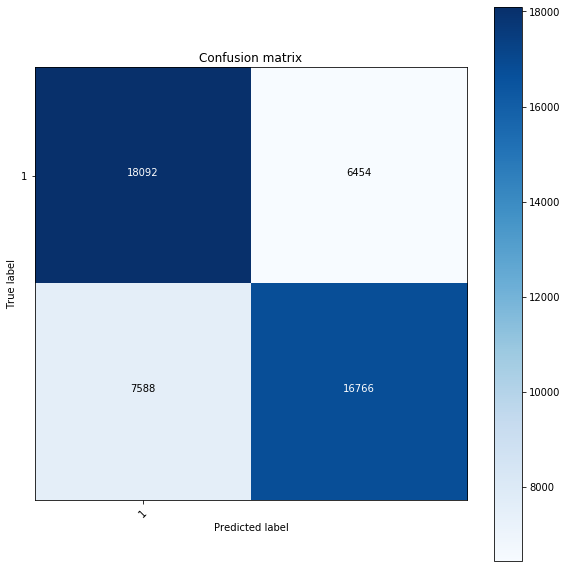

In [37]:
cnf = confusion_matrix(y_test, rf.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

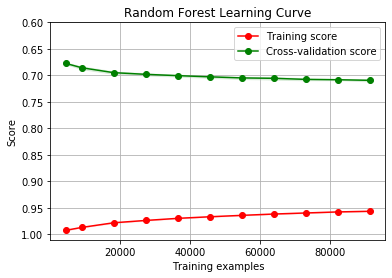

In [38]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest Learning Curve", X_train, y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 68.20 %
Confusion matrix, without normalization
[[17327  7219]
 [ 8329 16025]]


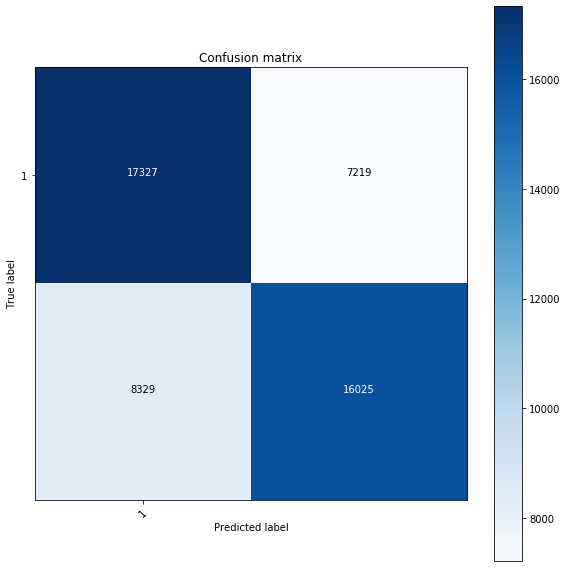

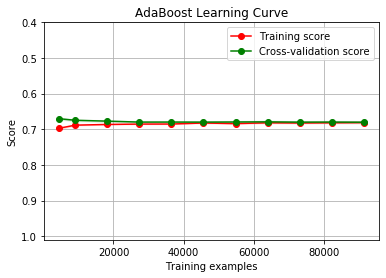

In [39]:
ada = Classifier(clf = AdaBoostClassifier)
ada.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
ada.grid_fit(X_train, y_train)
ada.grid_predict(X_test, y_test)
cnf = confusion_matrix(y_test, ada.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost Learning Curve", X_train, y_train, ylim=[1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [42]:
import xgboost

from sklearn.ensemble import VotingClassifier

In [43]:
gbdt = Classifier(clf = xgboost.XGBClassifier)
gbdt.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
gbdt.grid_fit(X_train, y_train)
gbdt.grid_predict(X_test, y_test)

Precision: 69.25 %


Confusion matrix, without normalization
[[17928  6618]
 [ 8418 15936]]


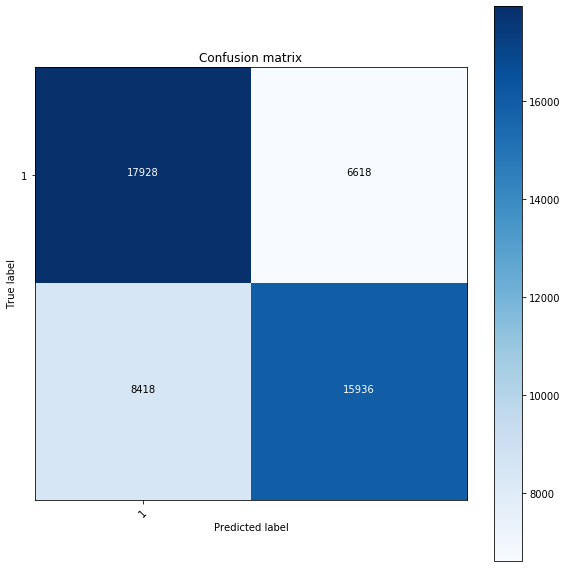

In [44]:
cnf = confusion_matrix(y_test, gbdt.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

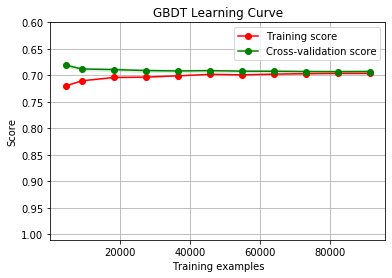

In [45]:
g = plot_learning_curve(gbdt.grid.best_estimator_, "GBDT Learning Curve", X_train, y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [46]:
rf_best = RandomForestClassifier(**rf.grid.best_params_)
gbdt_best = xgboost.XGBClassifier(**gbdt.grid.best_params_)
svc_best = LinearSVC(**svc.grid.best_params_)
tr_best = DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = KNeighborsClassifier(**knn.grid.best_params_)
lr_best = LogisticRegression(**lr.grid.best_params_)

In [47]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('gb', gbdt_best), ('knn', knn_best), ('lr', lr_best)])
votingC = votingC.fit(X_train, y_train)
predictions = votingC.predict(X_test)
print("Precision : {:.2f}%".format(100 * accuracy_score(y_test, predictions)))

Precision : 69.38%


In [51]:
precision_recall_fscore_support(predictions, y_test)

(array([0.77, 0.61]),
 array([0.67, 0.73]),
 array([0.72, 0.67]),
 array([28335, 20565], dtype=int64))

In [146]:
rf_best = RandomForestClassifier(**rf.grid.best_params_)
rf_best.fit(X_train, y_train)
rf_prediction = rf_best.predict(X_test)
precision_recall_fscore_support(rf_prediction, y_test)

(array([0.74, 0.69]),
 array([0.7 , 0.72]),
 array([0.72, 0.7 ]),
 array([25758, 23142], dtype=int64))

In [148]:
y_hat = rf_best.predict(X)

In [149]:
y_probs = rf_best.predict_proba(X)

In [150]:
training.shape

(162997, 15)

In [151]:
y_hat.shape

(162997,)

In [152]:
training["prediction"] = y_hat

In [153]:
training["zero_probs"] = y_probs[:,0]
training["one_probs"] = y_probs[:,1]

In [154]:
wrong_predictions = training[training.prediction != training.l8]

In [247]:
wrong_predictions.to_csv("wrong_predictions-combined.csv")

In [ ]:
wrong_predictions.shape

In [129]:
wrong_ones = wrong_predictions[wrong_predictions.l8 > 0]
wrong_zeros = wrong_predictions[wrong_predictions.l8 < 1]

In [130]:
wrong_ones.shape

(11781, 18)

In [131]:
wrong_zeros.shape

(7719, 18)

In [132]:
data_ones = training[training.l8 > 0]
data_zeros = training[training.l8 < 1]

In [133]:
data_ones.shape

(81498, 18)

In [134]:
data_zeros.shape

(81499, 18)

In [135]:
rf_best.feature_importances_

array([0.07, 0.11, 0.09, 0.15, 0.14, 0.14, 0.05, 0.06, 0.18])

In [136]:
all_cols = X.columns.values

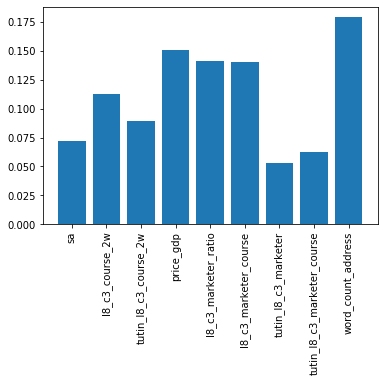

In [137]:
plt_indexs= list(range(1, len(rf_best.feature_importances_) + 1))
plt.bar(plt_indexs, rf_best.feature_importances_)
plt.xticks(plt_indexs, all_cols, rotation=90)
plt.show()

In [138]:
X.columns.values

array(['sa', 'l8_c3_course_2w', 'tutin_l8_c3_course_2w', 'price_gdp',
       'l8_c3_marketer_ratio', 'l8_c3_marketer_course',
       'tutin_l8_c3_marketer', 'tutin_l8_c3_marketer_course',
       'word_count_address'], dtype=object)

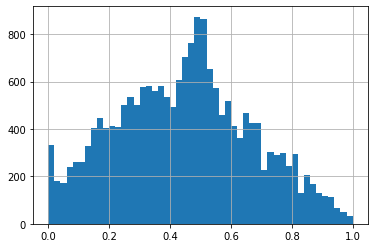

In [139]:
wrong_predictions.one_probs.hist(bins=50)

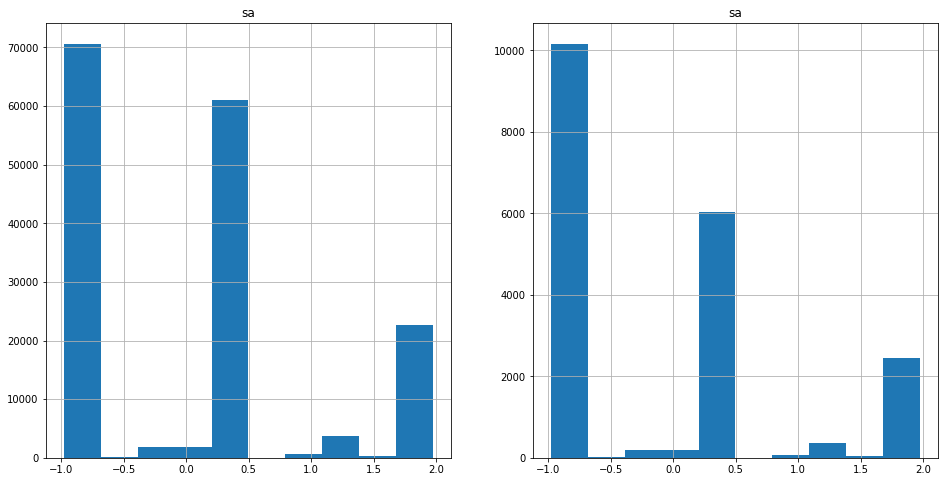

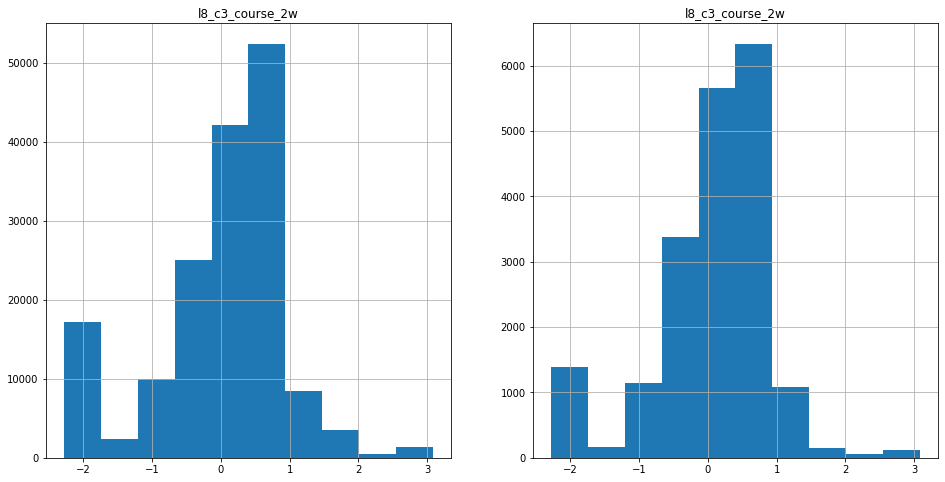

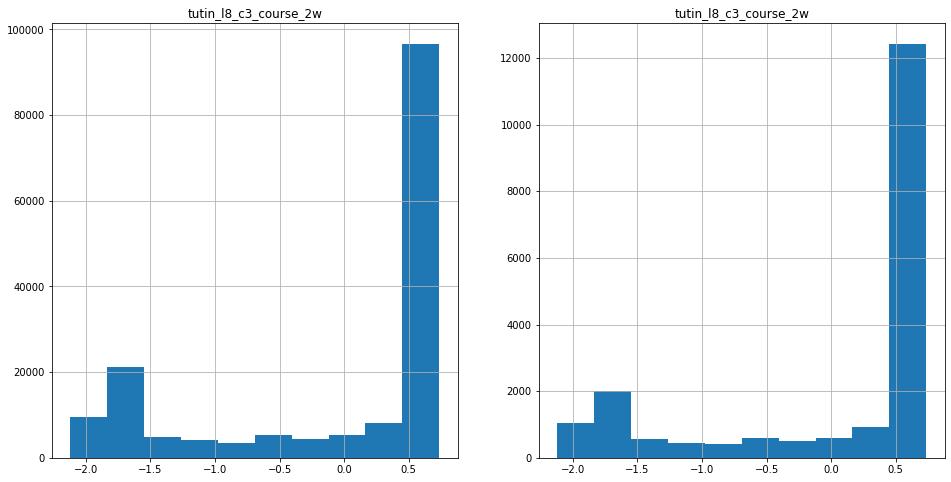

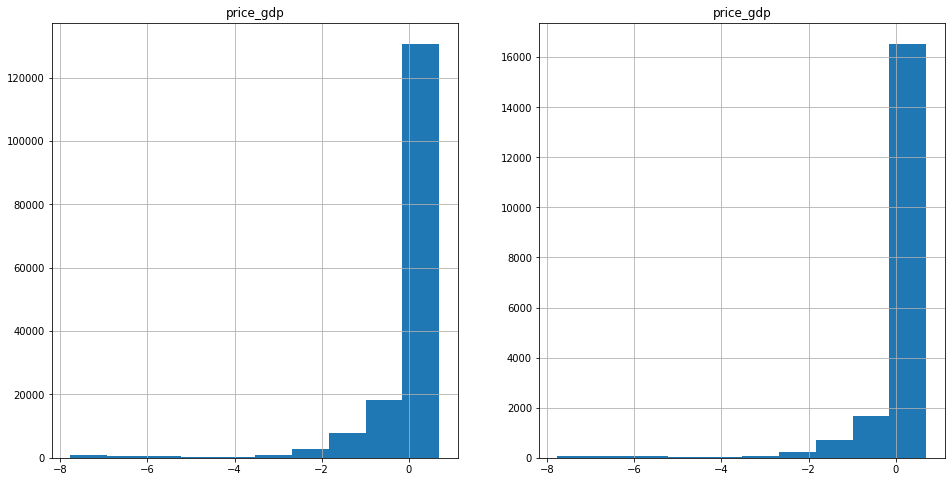

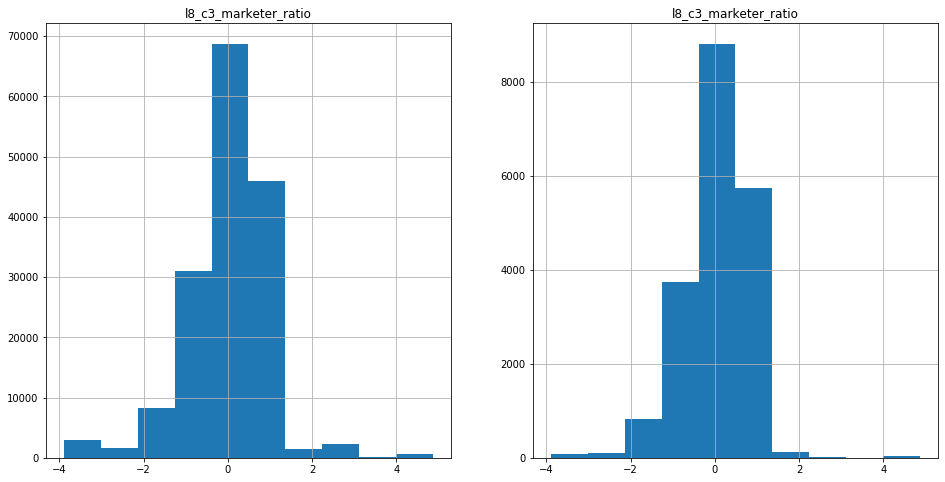

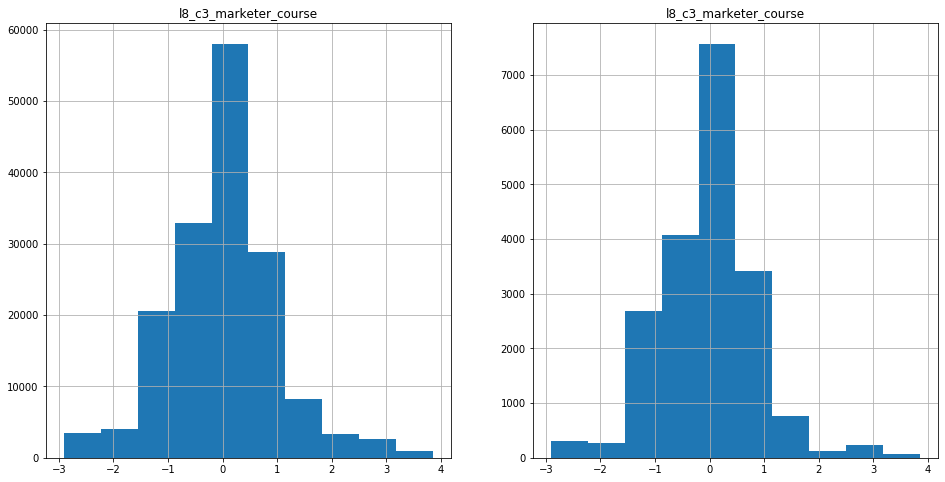

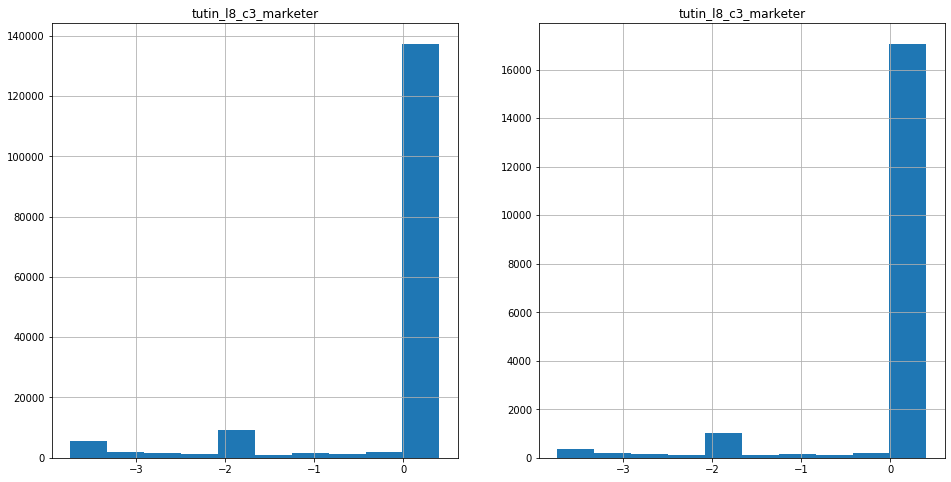

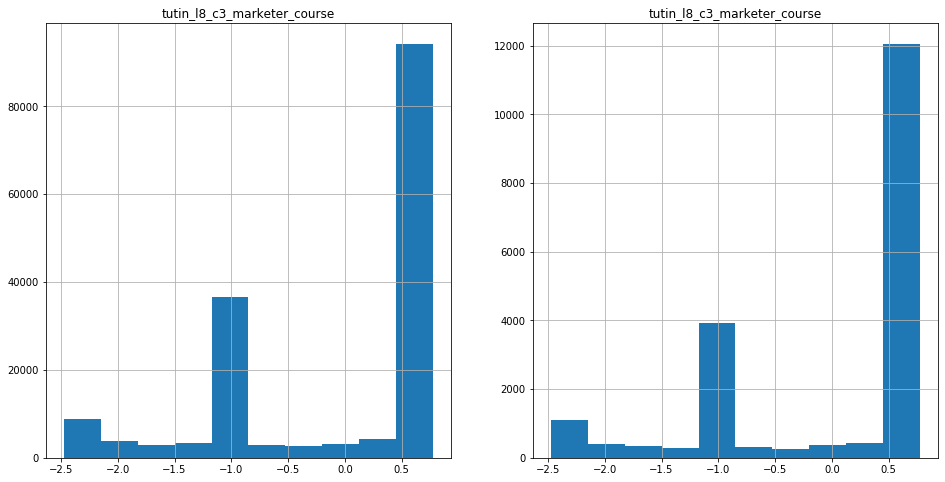

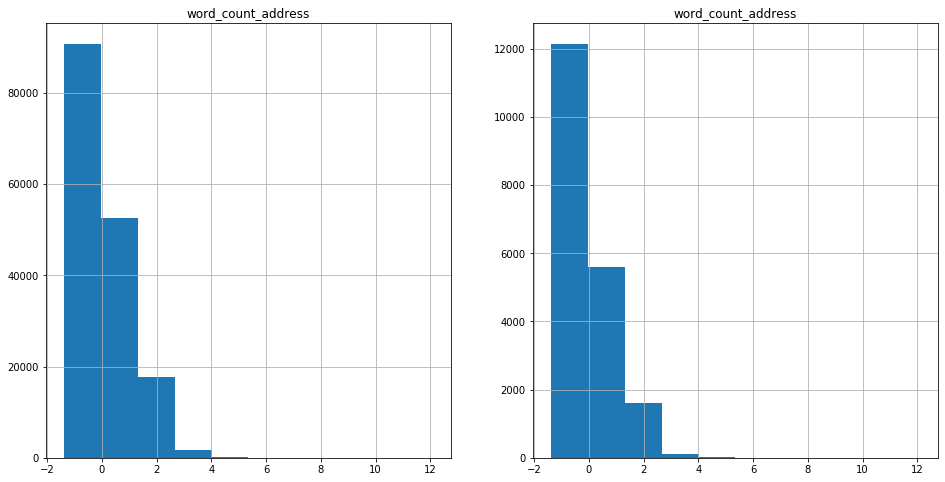

In [140]:
for col in all_cols:
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    X[col].hist()
    plt.title(col)
    
    plt.subplot(122)
    wrong_predictions[col].hist()
    plt.title(col)
    plt.show()

In [155]:
true_predictions = training[training.prediction == training.l8]
rf_prediction = rf_best.predict(true_predictions[all_cols])
precision_recall_fscore_support(rf_prediction, true_predictions.l8)

(array([1., 1.]),
 array([1., 1.]),
 array([1., 1.]),
 array([73730, 69688], dtype=int64))

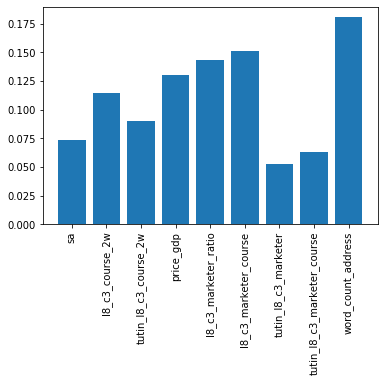

In [144]:
plt_indexs= list(range(1, len(rf_best.feature_importances_) + 1))
plt.bar(plt_indexs, rf_best.feature_importances_)
plt.xticks(plt_indexs, all_cols, rotation=90)
plt.show()

In [156]:
from sklearn.externals import joblib
joblib.dump(rf.grid.best_params_, 'rf.grid.best_params.pkl', compress = 1) # Only best parameters

['rf.grid.best_params.pkl']

In [157]:
joblib.dump(rf_best, 'rf_best.model.pkl')

['rf_best.model.pkl']

In [159]:
rf_wrong_prediction = rf_best.predict(wrong_predictions[all_cols])
precision_recall_fscore_support(rf_wrong_prediction, wrong_predictions.l8)

(array([0., 0.]),
 array([0., 0.]),
 array([0., 0.]),
 array([11810,  7769], dtype=int64))

In [192]:
training["is_anomaly"] = 1.0
training["is_anomaly"][training.prediction == training.l8] = 0.0

In [196]:
training[training["is_anomaly"] > 0].shape

(19579, 19)

In [198]:
anomaly = training[training["is_anomaly"] > 0]
anomaly.shape

(19579, 19)

In [199]:
training[training["is_anomaly"] < 1].shape

(143418, 19)

In [200]:
normal = training[training["is_anomaly"] < 1]
normal.shape

(143418, 19)

In [201]:
new_training_anomaly = pd.concat([anomaly, normal.iloc[:anomaly.shape[0], :]])

In [204]:
new_training_anomaly.shape

(39158, 19)

In [205]:
new_training_anomaly[new_training_anomaly["is_anomaly"] < 1].shape

(19579, 19)

In [206]:
new_training_anomaly[new_training_anomaly["is_anomaly"] > 0].shape

(19579, 19)

In [220]:
X_train_anomaly, X_test_anomaly, y_train_anomaly, y_test_anomaly = train_test_split(new_training_anomaly[all_cols + ["one_probs"]], new_training_anomaly["is_anomaly"], test_size=0.3, random_state=42, shuffle=True)

Precision: 66.00 %
Confusion matrix, without normalization
[[3861 2029]
 [1965 3893]]


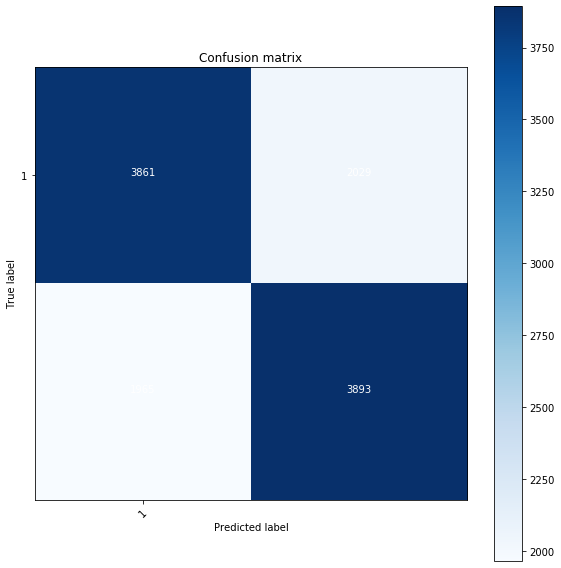

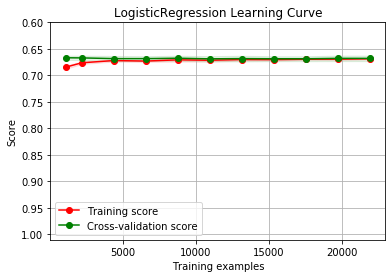

In [178]:
lr_anomaly = Classifier(clf = LogisticRegression)
lr_anomaly.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)
lr_anomaly.grid_fit(X_train_anomaly, y_train_anomaly)
lr_anomaly.grid_predict(X_test_anomaly, y_test_anomaly)

cnf = confusion_matrix(y_test_anomaly, lr_anomaly.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

g = plot_learning_curve(lr_anomaly.grid.best_estimator_, "LogisticRegression Learning Curve", X_train_anomaly, y_train_anomaly, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 70.28 %
Confusion matrix, without normalization
[[3752 2138]
 [1353 4505]]


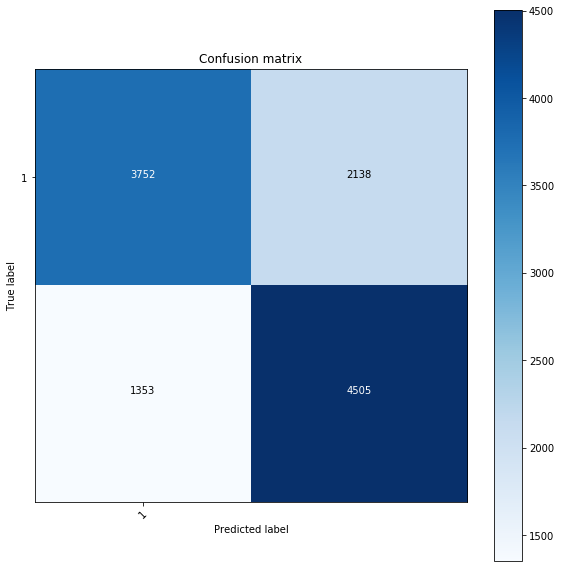

In [179]:
knn_anomaly = Classifier(clf = KNeighborsClassifier)
knn_anomaly.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn_anomaly.grid_fit(X_train_anomaly, y_train_anomaly)
knn_anomaly.grid_predict(X_test_anomaly, y_test_anomaly)
cnf = confusion_matrix(y_test_anomaly, knn_anomaly.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
g = plot_learning_curve(knn_anomaly.grid.best_estimator_, "KNearestNEighbors Learning Curve", X_train_anomaly, y_train_anomaly, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 69.40 %
Confusion matrix, without normalization
[[4092 1798]
 [1797 4061]]


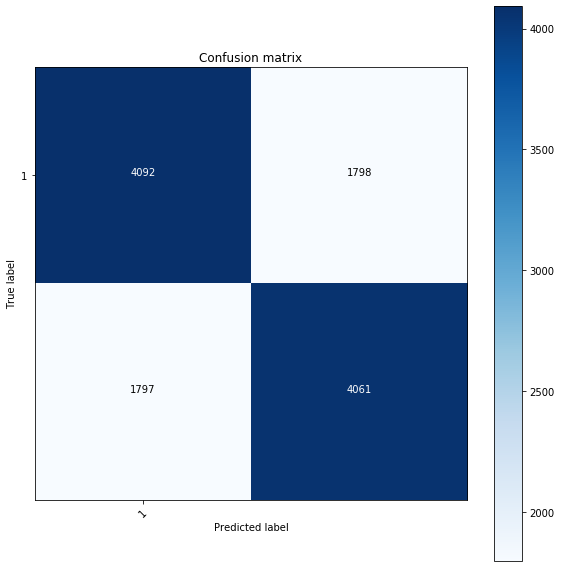

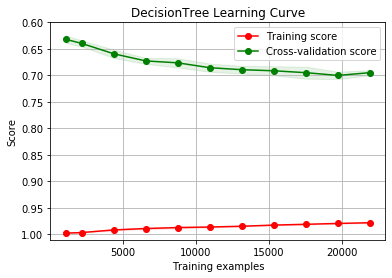

In [182]:
tr_anomaly = Classifier(clf = DecisionTreeClassifier)
tr_anomaly.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr_anomaly.grid_fit(X_train_anomaly, y_train_anomaly)
tr_anomaly.grid_predict(X_test_anomaly, y_test_anomaly)
cnf = confusion_matrix(y_test_anomaly, tr_anomaly.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

g = plot_learning_curve(tr_anomaly.grid.best_estimator_, "DecisionTree Learning Curve", X_train_anomaly, y_train_anomaly, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 74.35 %
Confusion matrix, without normalization
[[4728 1130]
 [1883 4007]]


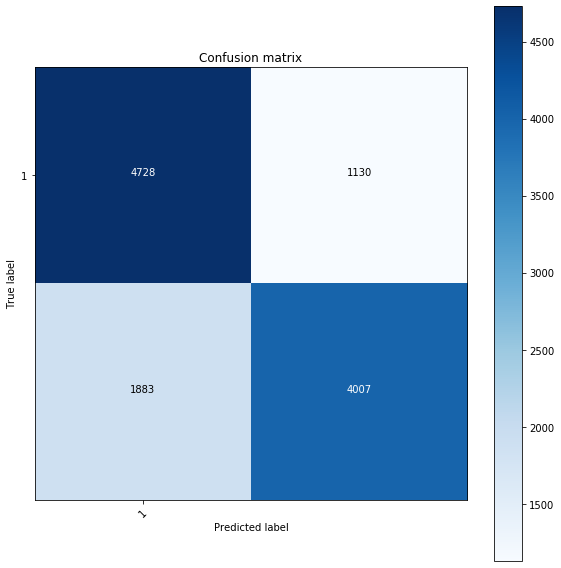

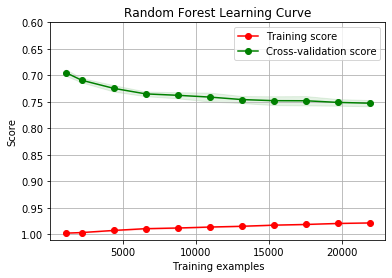

In [208]:
rf_anomaly = Classifier(clf = RandomForestClassifier)
rf_anomaly.grid_search(parameters = [{'criterion':['entropy', 'gini'], 
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf_anomaly.grid_fit(X_train_anomaly, y_train_anomaly)
rf_anomaly.grid_predict(X_test_anomaly, y_test_anomaly)
cnf = confusion_matrix(y_test_anomaly, rf_anomaly.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
g = plot_learning_curve(rf_anomaly.grid.best_estimator_, "Random Forest Learning Curve", X_train_anomaly, y_train_anomaly, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 70.17 %
Confusion matrix, without normalization
[[3910 1980]
 [1524 4334]]


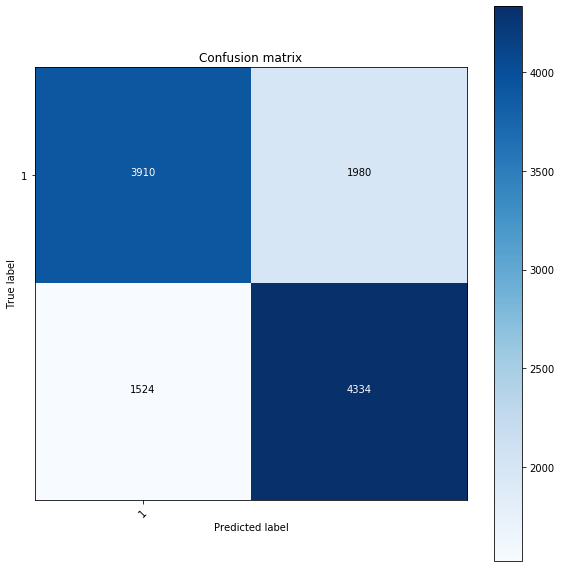

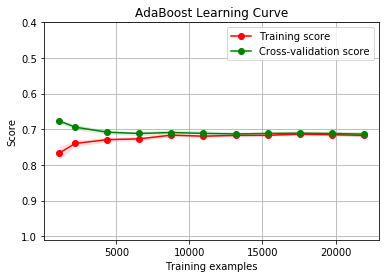

In [184]:
ada_anomaly = Classifier(clf = AdaBoostClassifier)
ada_anomaly.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
ada_anomaly.grid_fit(X_train_anomaly, y_train_anomaly)
ada_anomaly.grid_predict(X_test_anomaly, y_test_anomaly)
cnf = confusion_matrix(y_test_anomaly, ada_anomaly.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
g = plot_learning_curve(ada_anomaly.grid.best_estimator_, "AdaBoost Learning Curve", X_train_anomaly, y_train_anomaly, ylim=[1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

Precision: 73.51 %
Confusion matrix, without normalization
[[3869 2021]
 [1091 4767]]


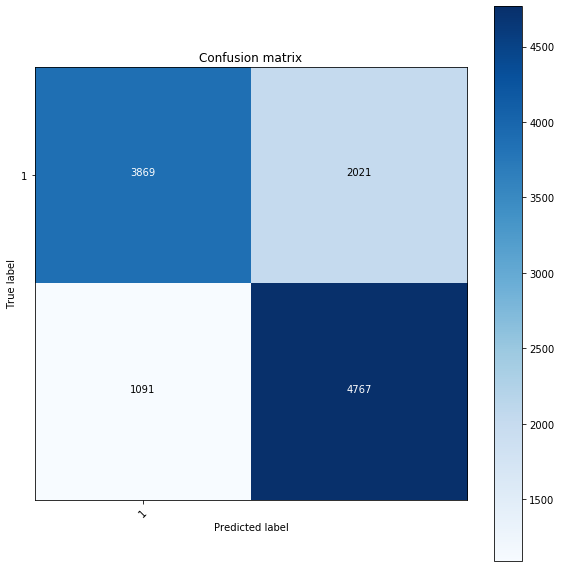

In [185]:
gbdt_anomaly = Classifier(clf = xgboost.XGBClassifier)
gbdt_anomaly.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
gbdt_anomaly.grid_fit(X_train_anomaly, y_train_anomaly)
gbdt_anomaly.grid_predict(X_test_anomaly, y_test_anomaly)
cnf = confusion_matrix(y_test_anomaly, gbdt_anomaly.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [188]:
rf_best_anomaly = RandomForestClassifier(**rf_anomaly.grid.best_params_)
gbdt_best_anomaly = xgboost.XGBClassifier(**gbdt_anomaly.grid.best_params_)
tr_best_anomaly = DecisionTreeClassifier(**tr_anomaly.grid.best_params_)
knn_best_anomaly = KNeighborsClassifier(**knn_anomaly.grid.best_params_)
lr_best_anomaly = LogisticRegression(**lr_anomaly.grid.best_params_)

votingC_anomaly = VotingClassifier(estimators=[('rf', rf_best_anomaly), ('gb', gbdt_best_anomaly), ('knn', knn_best_anomaly), ('lr', lr_best_anomaly)])
votingC_anomaly = votingC_anomaly.fit(X_train_anomaly, y_train_anomaly)
predictions = votingC_anomaly.predict(X_test_anomaly)
print("Precision : {:.2f}%".format(100 * accuracy_score(y_test_anomaly, predictions)))

Precision : 73.29%


In [189]:
precision_recall_fscore_support(y_test_anomaly, predictions
                                

(array([0.74, 0.73]),
 array([0.72, 0.74]),
 array([0.73, 0.74]),
 array([5890, 5858], dtype=int64))

In [190]:
precision_recall_fscore_support(y_test_anomaly, rf_anomaly.predictions)

(array([0.78, 0.72]),
 array([0.68, 0.8 ]),
 array([0.73, 0.76]),
 array([5890, 5858], dtype=int64))

In [191]:
new_training_anomaly.shape

(39158, 19)

In [221]:
rf_best_anomaly = RandomForestClassifier(**rf_anomaly.grid.best_params_)
rf_best_anomaly.fit(X_train_anomaly, y_train_anomaly)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [224]:
predictions = rf_best_anomaly.predict(X_test_anomaly)
print("Precision : {:.2f}%".format(100 * accuracy_score(y_test_anomaly, predictions)))

Precision : 85.80%


In [225]:
precision_recall_fscore_support(y_test_anomaly, predictions)

(array([0.83, 0.89]),
 array([0.89, 0.82]),
 array([0.86, 0.85]),
 array([5858, 5890], dtype=int64))

In [227]:
predictions = rf_best_anomaly.predict(training[X_train_anomaly.columns.values])
precision_recall_fscore_support(training["is_anomaly"], predictions)


(array([0.97, 0.16]),
 array([0.36, 0.92]),
 array([0.52, 0.28]),
 array([143418,  19579], dtype=int64))

In [228]:
print("Precision : {:.2f}%".format(100 * accuracy_score(training["is_anomaly"], predictions)))

Precision : 42.56%


In [222]:
X_train_anomaly.head()

sa  l8_c3_course_2w  tutin_l8_c3_course_2w  price_gdp  \
173653  0.399591        -0.441824               0.407214   0.595120   
199311  0.202773         0.779799               0.734988   0.477474   
105432  0.399591         0.599251              -0.319842   0.362334   
77385  -0.978138        -2.281193              -1.560791  -0.039497   
164575 -0.978138         0.310159               0.736238   0.348709   

        l8_c3_marketer_ratio  l8_c3_marketer_course  tutin_l8_c3_marketer  \
173653              0.071054              -0.894893              0.401934   
199311             -0.076145               0.854198              0.401934   
105432             -0.179534              -0.263652              0.401934   
77385              -1.181010              -2.194415              0.197238   
164575             -0.091040               0.393271              0.401934   

        tutin_l8_c3_marketer_course  word_count_address  one_probs  
173653                     0.776250            0.701943   0.870000  
199311                     0.776297           -0.581676   0.750000  
105432                     0.521464            1.022847   0.470000  
77385                     -0.858544            1.022847   0.120000  
164575                     0.776418           -0.260771   0.221802

Confusion matrix, without normalization
[[51273 92145]
 [ 1473 18106]]


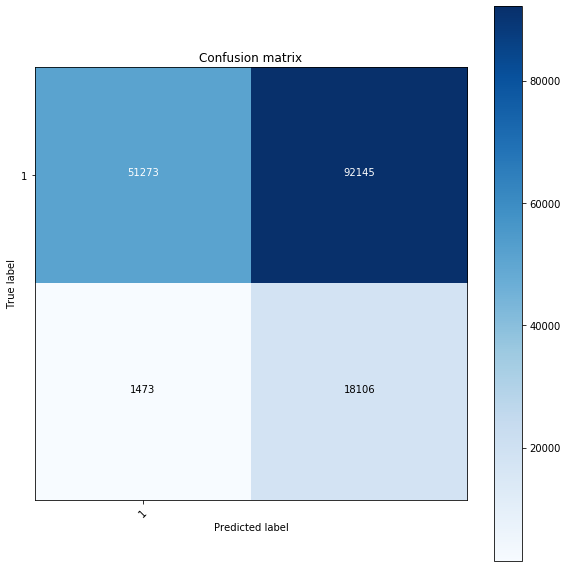

In [230]:
cnf = confusion_matrix(training["is_anomaly"], predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [248]:
clean_data = training[training.prediction == training.l8]
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(clean_data[all_cols], clean_data["l8"])
rf_best_true = RandomForestClassifier(**rf.grid.best_params_)
rf_best_true.fit(X_train_true, y_train_true)
rf_predictions_true = rf_best_true.predict(X_test_true)
precision_recall_fscore_support(rf_predictions_true, y_test_true)

(array([0.84, 0.82]),
 array([0.83, 0.83]),
 array([0.83, 0.82]),
 array([18651, 17204], dtype=int64))

Confusion matrix, without normalization
[[15500  3151]
 [ 3009 14195]]


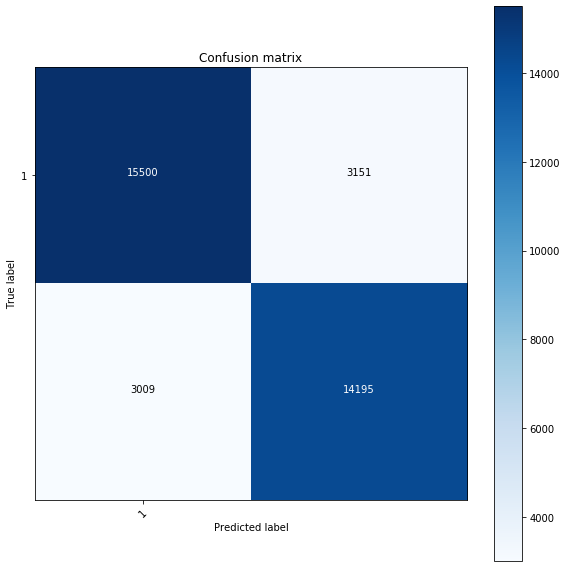

In [250]:
cnf = confusion_matrix(rf_predictions_true, y_test_true)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [249]:
clean_data.shape

(143418, 19)

Confusion matrix, without normalization
[[71877 14020]
 [ 9622 67478]]


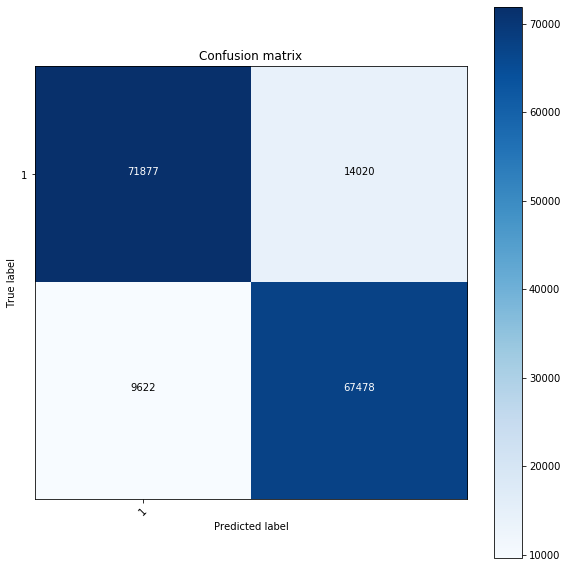

In [254]:
rf_predictions_total = rf_best_true.predict(X)
precision_recall_fscore_support(rf_predictions_total, y)
cnf = confusion_matrix(rf_predictions_total, y)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [255]:
precision_recall_fscore_support(rf_predictions_total, y)

(array([0.88, 0.83]),
 array([0.84, 0.88]),
 array([0.86, 0.85]),
 array([85897, 77100], dtype=int64))

In [252]:
y.shape

(162997,)

Confusion matrix, without normalization
[[18944  6980]
 [ 5602 17374]]


(array([0.77, 0.71]),
 array([0.73, 0.76]),
 array([0.75, 0.73]),
 array([25924, 22976], dtype=int64))

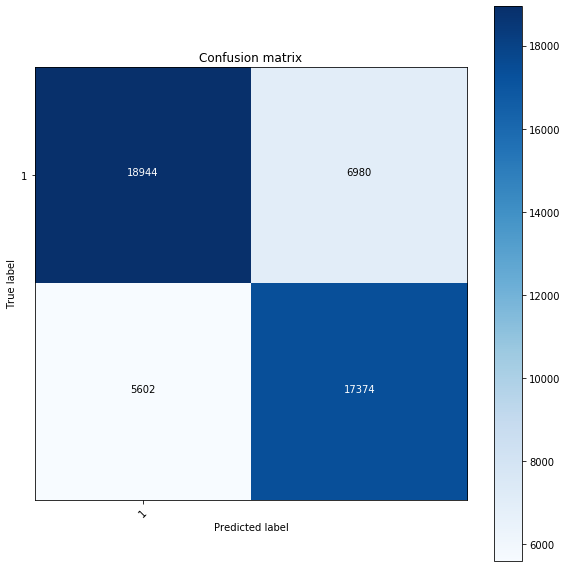

In [257]:
rf_predictions_test = rf_best_true.predict(X_test)
precision_recall_fscore_support(rf_predictions_test, y_test)
cnf = confusion_matrix(rf_predictions_test, y_test)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
precision_recall_fscore_support(rf_predictions_test, y_test)

In [258]:
print("Precision : {:.2f}%".format(100 * accuracy_score(rf_predictions_test, y_test)))

Precision : 74.27%


In [260]:
print("X_train:", X_train_true.shape)
print("X_test:", X_test_true.shape)
precision_recall_fscore_support(rf_predictions_true, y_test_true)

X_train: (107563, 9)
X_test: (35855, 9)


(array([0.84, 0.82]),
 array([0.83, 0.83]),
 array([0.83, 0.82]),
 array([18651, 17204], dtype=int64))

In [261]:
joblib.dump(rf_best_true, 'rf_best.model.cleaned-data.pkl')

['rf_best.model.cleaned-data.pkl']

In [262]:
clean_data.to_csv("clean_data.csv")

In [263]:
rf_predictions_total = rf_best_true.predict(X)
rf_probs_total = rf_best_true.predict_proba(X)
precision_recall_fscore_support(rf_predictions_total, y)

(array([0.88, 0.83]),
 array([0.84, 0.88]),
 array([0.86, 0.85]),
 array([85897, 77100], dtype=int64))

In [264]:
X.shape

(162997, 9)

In [265]:
training.shape

(162997, 19)

In [266]:
training.columns.values

array(['created_at', 'sa', 'price', 'l8_c3_course_2w',
       'tutin_l8_c3_course_2w', 'c3_course_buyed_1w', 'gdp_province',
       'l8_c3_marketer_ratio', 'l8_c3_marketer_course',
       'tutin_l8_c3_marketer', 'tutin_l8_c3_marketer_course',
       'contact_id', 'l8', 'word_count_address', 'price_gdp',
       'prediction', 'zero_probs', 'one_probs', 'is_anomaly'],
      dtype=object)

In [267]:
training["y_hat"] = rf_predictions_total
training["probs"] = rf_probs_total[:, 1]

In [268]:
training.shape

(162997, 21)

In [269]:
training.columns

Index(['created_at', 'sa', 'price', 'l8_c3_course_2w', 'tutin_l8_c3_course_2w',
       'c3_course_buyed_1w', 'gdp_province', 'l8_c3_marketer_ratio',
       'l8_c3_marketer_course', 'tutin_l8_c3_marketer',
       'tutin_l8_c3_marketer_course', 'contact_id', 'l8', 'word_count_address',
       'price_gdp', 'prediction', 'zero_probs', 'one_probs', 'is_anomaly',
       'y_hat', 'probs'],
      dtype='object')

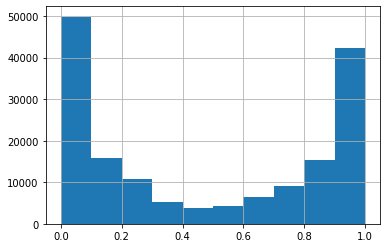

In [271]:
training.probs.hist()

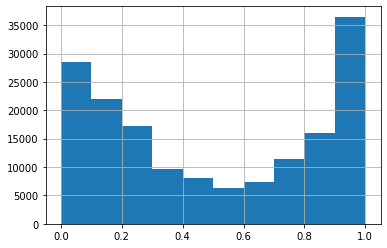

In [272]:
training.one_probs.hist()

In [273]:
training["probs_cat"] = pd.cut(training.probs, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
training["probs_cat"] = training["probs_cat"].apply(lambda x: x.right)


In [348]:
def plot(df):
    tmp = training.groupby("probs_cat")["contact_id"].count().reset_index()
    df["is_right"] = 0
    df["is_right"][df["l8"] == df["y_hat"]] = 1
    tmp2 = training.groupby("probs_cat")["is_right"].mean().reset_index()
    tmp["accuracy"] = tmp2["is_right"]
    def convert(x):
        if x.probs_cat < 0.5:
            x["crate"] = (1 - x.accuracy)*x.contact_id
        else:
            x["crate"] = x.accuracy*x.contact_id
        return x
    tmp = tmp.apply(lambda x: convert(x), axis=1)
    print(tmp)
    
    plt.figure(figsize=(16, 8))
    plt.bar(tmp.index, tmp.contact_id, label="Number of contacts")
    plt.bar(tmp.index, tmp.crate, label="Converted Contact C3")
    
    plt.legend()
    plt.xticks(tmp.index, tmp.probs_cat)
    plt.xlabel("Rank C3")
    plt.ylabel("Number of contacts")
    
    plt.twinx()
    plt.plot(tmp.index, tmp2.is_right, "ro-")
    plt.ylabel("Accuracy in each ranking C3")
    plt.show()

   probs_cat  contact_id  accuracy    crate
0        0.1       33161  0.875728   4121.0
1        0.2       15427  0.877812   1885.0
2        0.3        9651  0.798466   1945.0
3        0.4        5550  0.655495   1912.0
4        0.5        3768  0.526274   1983.0
5        0.6        4008  0.491517   1970.0
6        0.7        6489  0.658499   4273.0
7        0.8       10099  0.808793   8168.0
8        0.9       16024  0.883300  14154.0
9        1.0       40480  0.961290  38913.0


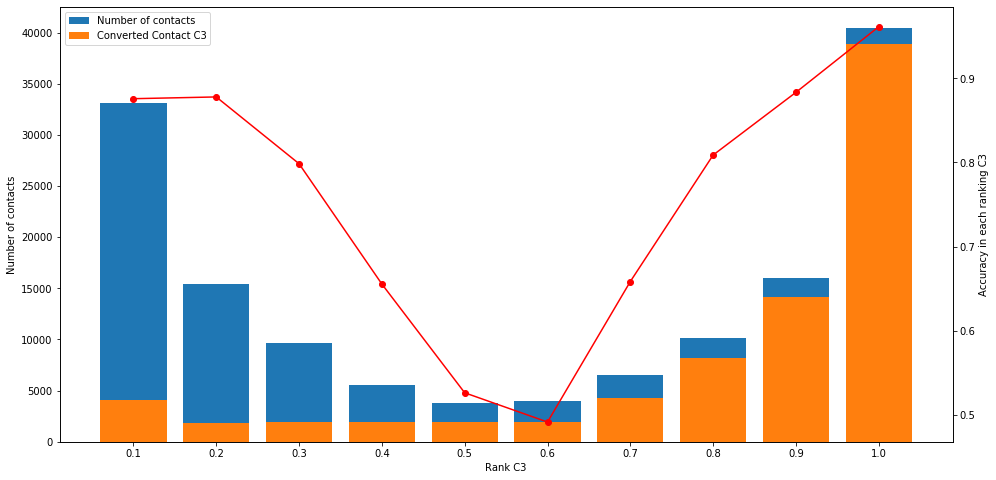

In [349]:
plot(training)